# Importing all the necessary Libraries


In [9]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

# Visualising the dataset


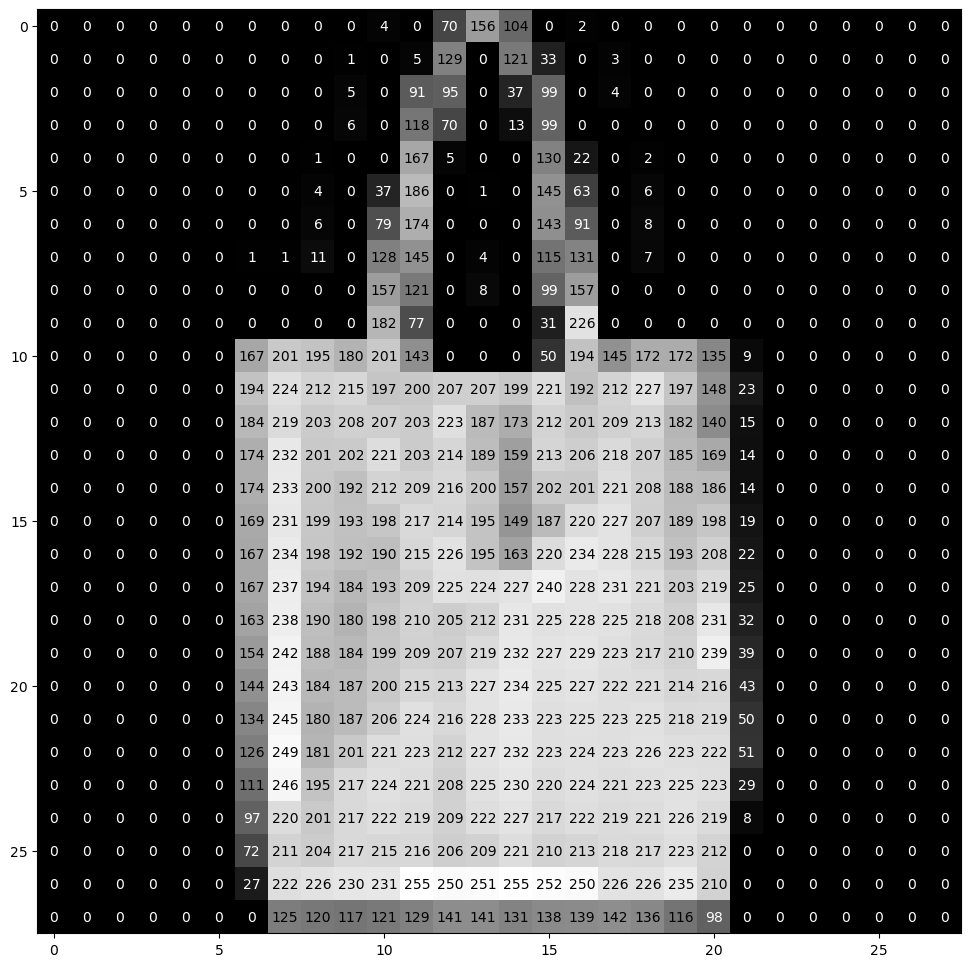

In [10]:
(training, _), (_, _) = fashion_mnist.load_data()

X_train = training/ 127.5-1
X_train = np.expand_dims(X_train, axis=3)   #Rescaling the data to [-1,1]

def visualize_input(img, ax):
    ax.imshow(img, cmap= 'gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy = (y, x),
                        horizontalalignment = 'center',
                        verticalalignment = 'center',
                        color = 'white' if img[x][y] < thresh else 'black')

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
visualize_input(training[3343], ax)


# Building the generator

In [11]:
def build_generator():
    generator = Sequential()
    
    generator.add(Dense(128 * 7 * 7, activation = 'relu', input_dim = 100))
    
    generator.add(Reshape((7, 7, 128)))
    
    generator.add(UpSampling2D())
    
    generator.add(Conv2D(1024, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(UpSampling2D())
    
    generator.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    
    
    generator.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
    generator.add(BatchNormalization(momentum=0.8))
    
    generator.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))
    
    generator.summary()
    
    noise = Input(shape=(100,))
    
    fake_image = generator(noise)
    
    return Model(inputs=noise, outputs=fake_image)
    

# Building the Discriminator

In [12]:
def build_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(ZeroPadding2D(padding = ((0,1),(0,1))))
    discriminator.add(BatchNormalization(momentum = 0.8))
    
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.25))
    
    # discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    # discriminator.add(BatchNormalization(momentum=0.8))
    # discriminator.add(LeakyReLU(alpha=0.2))
    # discriminator.add(Dropout(0.25))    
    
    # discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    # discriminator.add(BatchNormalization(momentum=0.8))
    # discriminator.add(LeakyReLU(alpha=0.2))
    # discriminator.add(Dropout(0.25))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    img = Input(shape=(28,28,1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

# Building the Combined Model


In [13]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

discriminator.trainable = False

generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)

combined = Model(inputs = z, outputs = valid)
combined.compile(loss='binary_crossentropy', optimizer = optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 1024)      1180672   
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 1024)     4096      
 hNormalization)                                                 
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 1024)    

ValueError: Exception encountered when calling layer "model_3" (type Functional).

Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 56, 56, 1)

Call arguments received by layer "model_3" (type Functional):
  • inputs=tf.Tensor(shape=(None, 56, 56, 1), dtype=float32)
  • training=None
  • mask=None

## Plotting function

In [6]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[examples,100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

# Building the training function 

In [7]:
def train(epochs, batch_size=128, save_interval=50):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(size=[batch_size, 100])
        gen_imgs = generator.predict_on_batch(noise)
        
        
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
        discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, valid)
        
        print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

2023-03-24 15:57:06.998690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-24 15:57:12.387919: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-24 15:57:16.519700: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-24 15:57:16.519926: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-24 15:57:19.219007: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of value

0 [D loss: 0.705134, acc: 40.62%] [G loss: 0.646569]
3/4 [=====================>........] - ETA: 0s

2023-03-24 15:57:27.636409: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-24 15:57:27.636619: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4/4 [==============================] - 2s 369ms/step
1 [D loss: 0.553663, acc: 46.88%] [G loss: 0.581934]
2 [D loss: 0.504347, acc: 56.25%] [G loss: 0.410251]
3 [D loss: 0.467174, acc: 60.94%] [G loss: 0.293956]
4 [D loss: 0.494516, acc: 60.94%] [G loss: 0.133415]
5 [D loss: 0.527369, acc: 51.56%] [G loss: 0.117778]
6 [D loss: 0.617444, acc: 59.38%] [G loss: 0.058735]
7 [D loss: 0.595907, acc: 67.19%] [G loss: 0.172563]
8 [D loss: 0.397904, acc: 81.25%] [G loss: 0.384492]
9 [D loss: 0.261198, acc: 96.88%] [G loss: 1.144391]
10 [D loss: 0.217799, acc: 95.31%] [G loss: 1.056860]
11 [D loss: 0.210106, acc: 96.88%] [G loss: 0.935400]
12 [D loss: 0.227111, acc: 96.88%] [G loss: 0.831199]
13 [D loss: 0.286524, acc: 93.75%] [G loss: 1.047559]
14 [D loss: 0.311806, acc: 89.06%] [G loss: 0.671575]
15 [D loss: 0.282350, acc: 87.50%] [G loss: 1.297801]
16 [D loss: 0.199639, acc: 92.19%] [G loss: 1.575835]
17 [D loss: 0.170416, acc: 100.00%] [G loss: 1.565061]
18 [D loss: 0.182002, acc: 100.00%] [

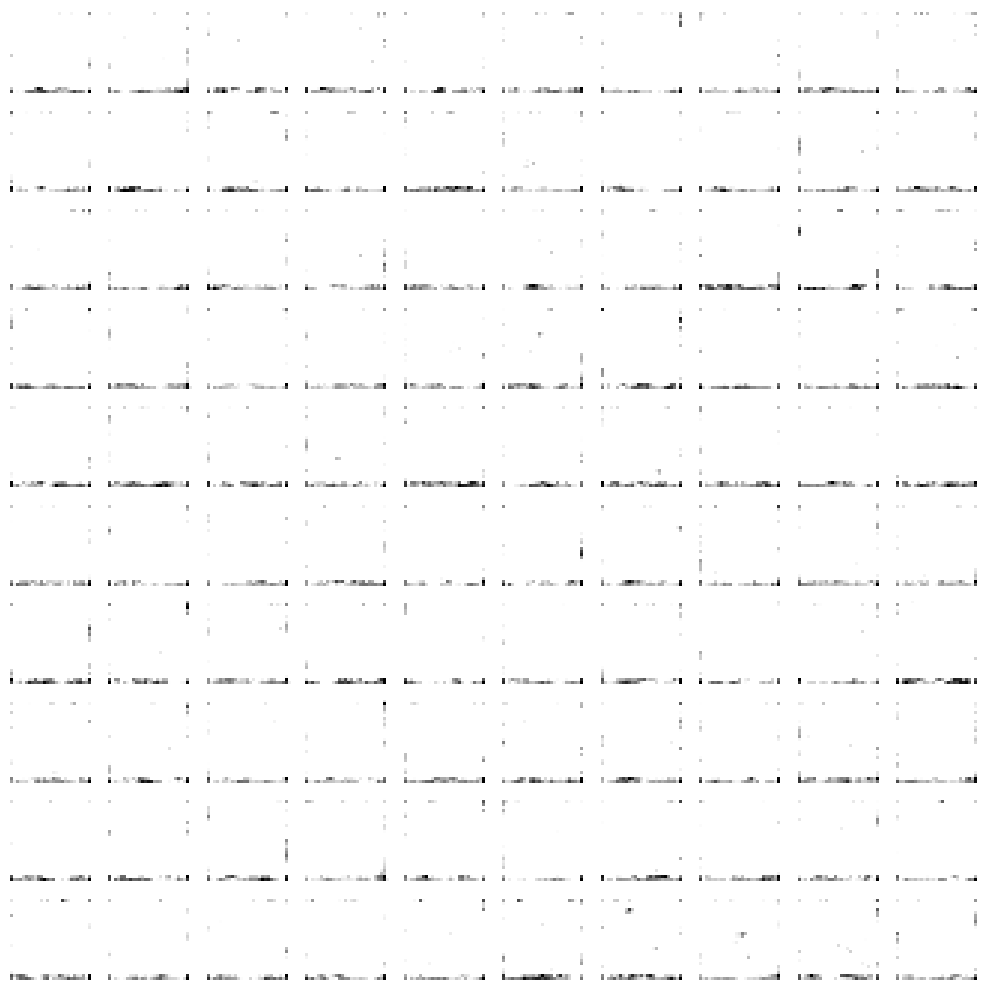

In [8]:
train(epochs=100, batch_size=32, save_interval=100)